## **1. Data Preparation** 
### Importing Libraries


In [42]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

### **1.1 Data Preprocessing**

In [43]:
# Define transformations: Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load MNIST datasets
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print sizes of training and testing datasets
print("Size of training dataset:", len(train_dataset))
print("Size of testing dataset:", len(test_dataset))

# Print feature and target names
feature_names = [f'Pixel {i}' for i in range(28 * 28)]  # Each image is 28x28 pixels
print("Feature Names:", feature_names)

target_names = [str(i) for i in range(10)]  # Digits 0-9
print("Target Names:", target_names)



Size of training dataset: 60000
Size of testing dataset: 10000
Feature Names: ['Pixel 0', 'Pixel 1', 'Pixel 2', 'Pixel 3', 'Pixel 4', 'Pixel 5', 'Pixel 6', 'Pixel 7', 'Pixel 8', 'Pixel 9', 'Pixel 10', 'Pixel 11', 'Pixel 12', 'Pixel 13', 'Pixel 14', 'Pixel 15', 'Pixel 16', 'Pixel 17', 'Pixel 18', 'Pixel 19', 'Pixel 20', 'Pixel 21', 'Pixel 22', 'Pixel 23', 'Pixel 24', 'Pixel 25', 'Pixel 26', 'Pixel 27', 'Pixel 28', 'Pixel 29', 'Pixel 30', 'Pixel 31', 'Pixel 32', 'Pixel 33', 'Pixel 34', 'Pixel 35', 'Pixel 36', 'Pixel 37', 'Pixel 38', 'Pixel 39', 'Pixel 40', 'Pixel 41', 'Pixel 42', 'Pixel 43', 'Pixel 44', 'Pixel 45', 'Pixel 46', 'Pixel 47', 'Pixel 48', 'Pixel 49', 'Pixel 50', 'Pixel 51', 'Pixel 52', 'Pixel 53', 'Pixel 54', 'Pixel 55', 'Pixel 56', 'Pixel 57', 'Pixel 58', 'Pixel 59', 'Pixel 60', 'Pixel 61', 'Pixel 62', 'Pixel 63', 'Pixel 64', 'Pixel 65', 'Pixel 66', 'Pixel 67', 'Pixel 68', 'Pixel 69', 'Pixel 70', 'Pixel 71', 'Pixel 72', 'Pixel 73', 'Pixel 74', 'Pixel 75', 'Pixel 76', 'Pixel 

#### 1.1.1 Data Augmentation

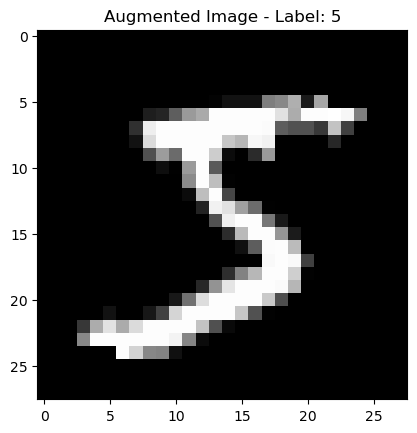

In [44]:
# Random rotation
augment_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

augmented_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=augment_transform)
# Visualize augmented images
image, label = augmented_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Augmented Image - Label: {label}')
plt.show()


### **1.2 Data Analysis and Visulaization**

#### 1.2.1 Sample Images- Visualization

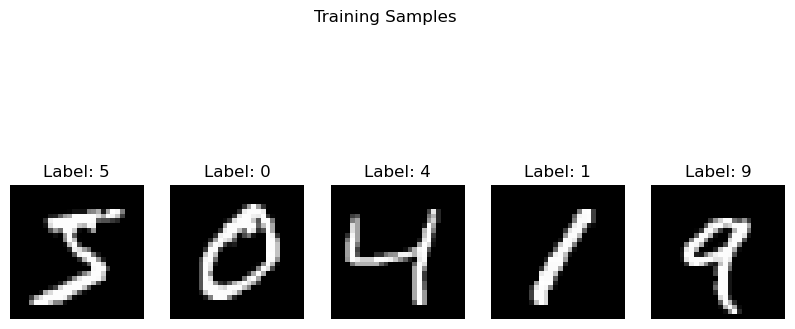

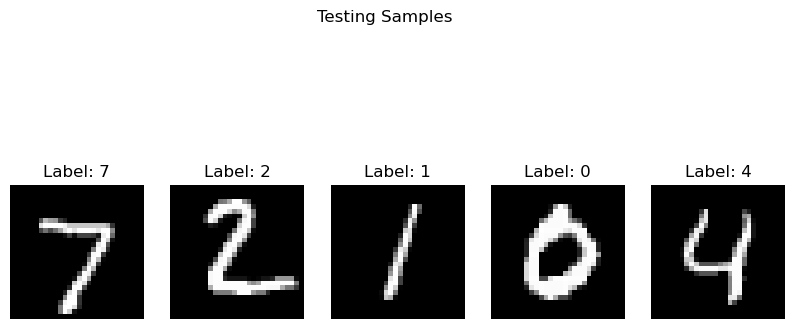

In [45]:
# Define a function to plot samples with labels
def plot_samples(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for visualization
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

# Define class names for MNIST (digits 0-9)
class_names = [str(i) for i in range(10)]

# Plot a few training samples
# Convert the first N images to a numpy array
N = 1000  # Number of images to use for correlation
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])  # Get corresponding labels
plot_samples(train_dataset.data.numpy()[:5], train_labels.numpy()[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

# Plot a few testing samples
test_images = torch.stack([test_dataset[i][0] for i in range(5)])  # Get first 5 test images
test_labels = torch.tensor([test_dataset[i][1] for i in range(5)])  # Get corresponding test labels
plot_samples(test_images.numpy(), test_labels.numpy(), class_names, num_samples=5)
plt.suptitle('Testing Samples')
plt.show()#plot 

#### 1.2.2 Mean and Standard Deviation

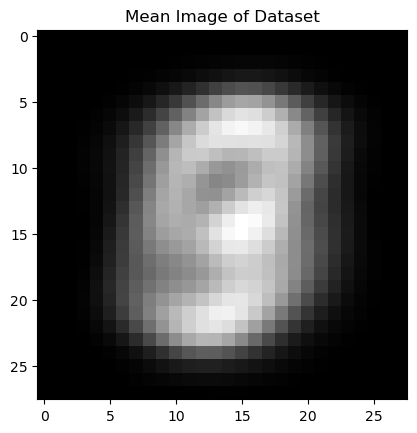

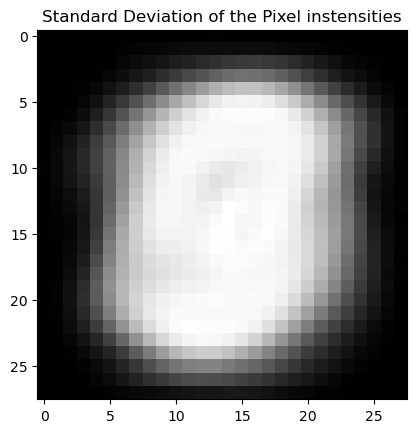

In [46]:
# Mean of dataset
mean_image = torch.mean(train_dataset.data.float(),dim=0)
plt.imshow(mean_image, cmap='gray')
plt.title("Mean Image of Dataset")
plt.show()

# Standard deviation of dataset
std_image = torch.std(train_dataset.data.float(),dim=0)
plt.imshow(std_image, cmap='gray')
plt.title("Standard Deviation of the Pixel instensities")
plt.show()

#### 1.2.3 Correlation Matrix of MNIST pixel values

c:\Users\Sandaru Dias\anaconda3\envs\ProjectCNN\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Sandaru Dias\anaconda3\envs\ProjectCNN\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


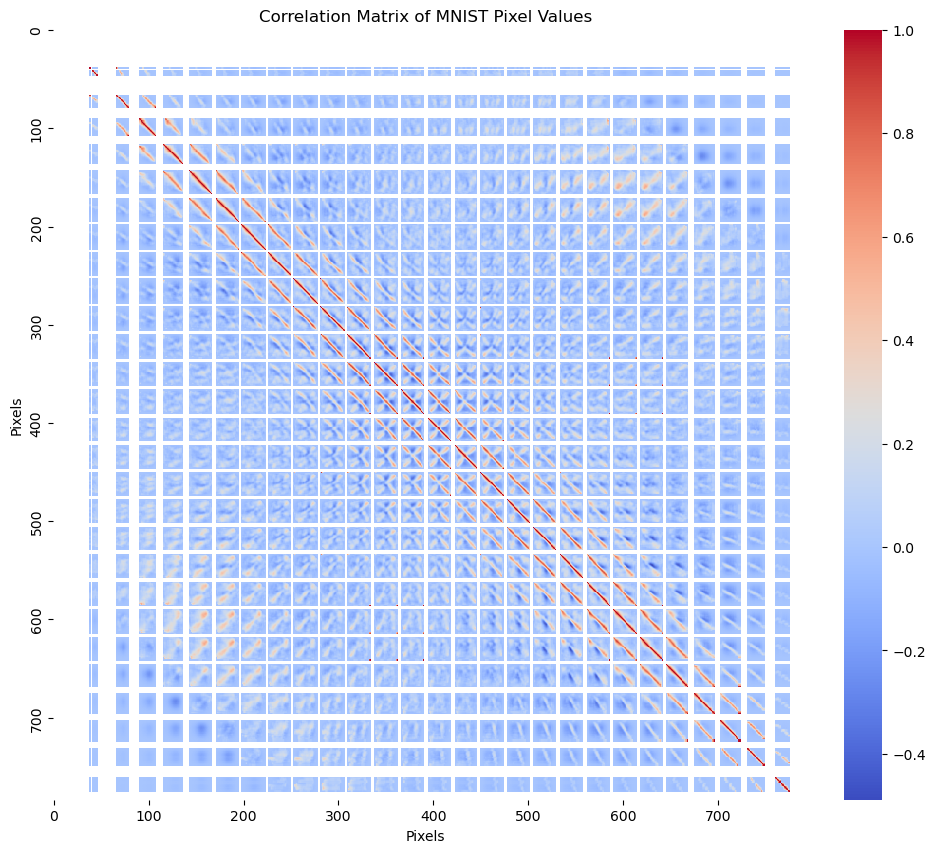

In [47]:
# Convert the first N images to a numpy array
N = 1000  # Number of images to use for correlation
train_images = torch.stack([train_dataset[i][0] for i in range(N)])  # Stack the images
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])  # Get corresponding labels
train_images = train_images.view(N, -1).numpy()  # Reshape to (N, 784)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)  # Transpose to get pixels on rows

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()



#### 1.2.4 Distribution of Digits

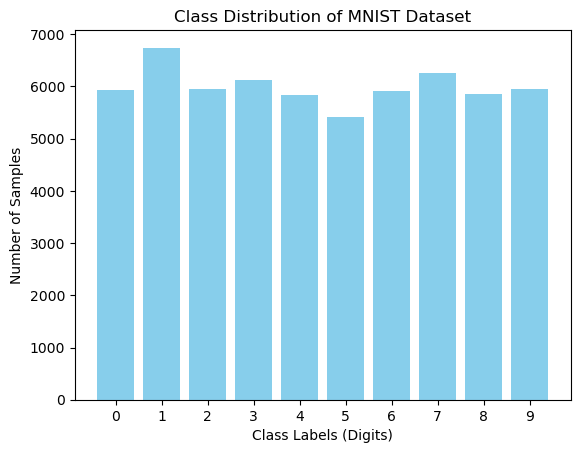

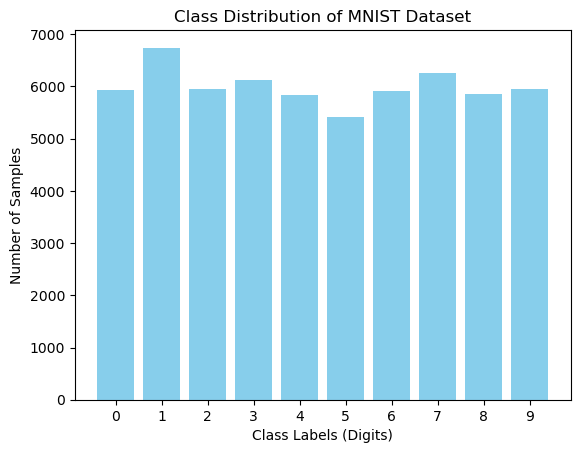

Total Training Samples: 60000
Total Testing Samples: 10000
Image Shape: torch.Size([1, 28, 28])


In [50]:
labels = train_dataset.targets

# Step 3:
def plot_class_distribution(labels):
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    
    # Create a bar plot for class distribution
    plt.bar(unique, counts, color='skyblue')
    plt.title('Class Distribution of MNIST Dataset')
    plt.xlabel('Class Labels (Digits)')
    plt.ylabel('Number of Samples')
    plt.xticks(unique)  # Set x-axis ticks to be the class labels
    plt.show()

# Step 4: Call the function to plot the class distribution
plot_class_distribution(labels)

# Plot the class distribution
plot_class_distribution(labels)

# Print some statistics about the dataset
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")

#### 1.2.5 Principal Component Analysis (PCA) on dataset

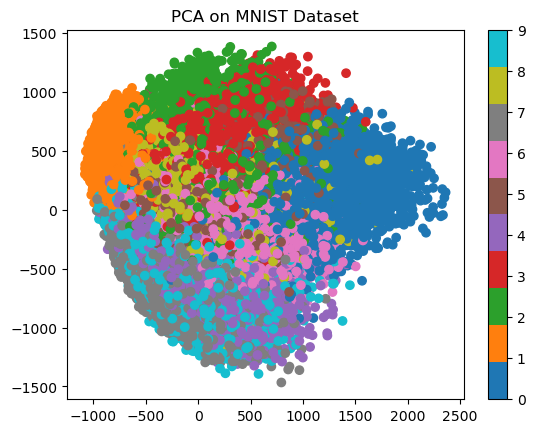

In [24]:
# Flatten the images for PCA
data = train_dataset.data.view(-1, 28*28).numpy()
labels = train_dataset.targets.numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()